## Prepare the linear system from Chorin's Projection

In [145]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Lx = 1              # length of domian in x-direction
Ly = 1              # length of domian in y-direction
nx = 4              # grid size in x-direction
ny = 4              # grid size in y-direction

Re = 100            # Reynolds number
nu = 1/Re           # kinematic viscosity
rho = 1.0           # density
dt =  1             # time step size
itr = 10             # iterations
velocity = 1.0

# Create staggered grid index system
imin, jmin = 1, 1
imax = imin + nx - 1
jmax = jmin + ny - 1

# Define ghost cells for boundary conditions
x = np.zeros(jmax + 2)
y = np.zeros(jmax + 2)
x[imin: imax + 2] = np.linspace(0, Lx, nx + 1, endpoint=True)
y[jmin: jmax + 2] = np.linspace(0, Ly, ny + 1, endpoint=True)

dx = x[imin + 1] - x[imin]
dy = y[jmin + 1] - y[jmin]
dxi = 1 / dx
dyi = 1 / dy

# Define Laplacian
def Laplacian(nx, ny, dxi, dyi):
    Dx = np.diag(np.ones(nx)) * 2 - np.diag(np.ones(nx - 1), 1) - np.diag(np.ones(nx - 1), -1)
    Dx[0, 0] = 1
    Dx[-1, -1] = 1
    Ix = np.diag(np.ones(ny))
    Dy = np.diag(np.ones(ny)) * 2 - np.diag(np.ones(ny - 1), 1) - np.diag(np.ones(ny - 1), -1)
    Dy[0, 0] = 1
    Dy[-1, -1] = 1
    Iy = np.diag(np.ones(nx))
    L = np.kron(Ix, Dx) * dxi ** 2 + np.kron(Dy, Iy) * dyi ** 2
    return L

L = Laplacian(nx, ny, dxi, dyi)
# L[0,:]=0
L[0,0]=1


# Variable declaration
u = np.zeros((imax + 2, jmax + 2))
v = np.zeros((imax + 2, jmax + 2))

res_hist_classical = []
for timestep in tqdm(range(itr)):
    
    # u-momentum
    us = u.copy()
    u_old = u.copy()
    I = slice(imin + 1, imax + 1)
    Ib = slice(imin, imax)
    If = slice(imin + 2, imax + 2)
    J = slice(jmin, jmax + 1)
    Jb = slice(jmin - 1, jmax)
    Jf = slice(jmin + 1, jmax + 2)

    v_here = 0.25 * (v[Ib, J] + v[Ib, Jf] + v[I, J] + v[I, Jf])
    us[I, J] = u[I, J] + dt * (
            nu * (u[Ib, J] - 2 * u[I, J] + u[If, J]) * dxi ** 2
            + nu * (u[I, Jb] - 2 * u[I, J] + u[I, Jf]) * dyi ** 2
            - v_here * (u[I, Jf] - u[I, Jb]) * 0.5 * dyi
            - u[I, J] * (u[If, J] - u[Ib, J]) * 0.5 * dxi
    )


    # v-momentum
    vs = v.copy()
    v_old = v.copy()
    I = slice(imin, imax + 1)
    Ib = slice(imin - 1, imax)
    If = slice(imin + 1, imax + 2)
    J = slice(jmin + 1, jmax + 1)
    Jb = slice(jmin, jmax)
    Jf = slice(jmin + 2, jmax + 2)

    u_here = 0.25 * (u[I, Jb] + u[I, J] + u[If, Jb] + u[If, J])
    vs[I, J] = v[I, J] + dt * (
            nu * (v[Ib, J] - 2 * v[I, J] + v[If, J]) * dxi ** 2
            + nu * (v[I, Jb] - 2 * v[I, J] + v[I, Jf]) * dyi ** 2
            - u_here * (v[If, J] - v[Ib, J]) * 0.5 * dxi
            - v[I, J] * (v[I, Jf] - v[I, Jb]) * 0.5 * dyi
    )


    # Claculate R.H.S of pressure Poisson
    Rn = -rho / dt * ((us[imin + 1: imax + 2, jmin: jmax + 1]
                       - us[imin: imax + 1, jmin: jmax + 1]) * dxi
                      + (vs[imin: imax + 1, jmin + 1: jmax + 2]
                       - vs[imin: imax + 1, jmin: jmax + 1]) * dyi)
    
    R = Rn.T.ravel()
    
    # Prepare linear system for VQLS
    pv = np.linalg.solve(L, R)

    pn = pv.reshape(ny, nx).T
    p = np.zeros((imax + 1, jmax + 1))
    p[1:, 1:] = pn
    p[0, 0] = 0


    # Correct velocity
    u[imin + 1: imax + 1, jmin: jmax + 1] = us[imin + 1: imax + 1, jmin: jmax + 1] - dt / rho * (
                p[imin + 1: imax + 1, jmin: jmax + 1] - p[imin: imax, jmin: jmax + 1]) * dxi
    v[imin: imax + 1, jmin + 1: jmax + 1] = vs[imin: imax + 1, jmin + 1: jmax + 1] - dt / rho * (
                p[imin: imax + 1, jmin + 1: jmax + 1] - p[imin: imax + 1, jmin: jmax]) * dyi
    
    # Update BCs
    v[imin,:] = 0.0                   # left wall
    v[imax+1,:] = 0.0                 # right wall
    v[:, jmin-1] = -v[:, jmin]        # bottom wall
    v[:, jmax+1] = -v[:, jmax]        # top wall

    u[imin-1, :] = -u[imin, :]        # left wall
    u[imax+1, :] = -u[imax, :]        # right wall
    u[:,imin] = 0                     # bottom wall
    u[:,imax+1] = velocity            # top wall
    
    # Find maximum residual in the domain
    v_res = np.abs(v - v_old)
    u_res = np.abs(u - u_old)
    max_res_u = np.max(u_res)
    max_res_v = np.max(v_res)
    max_res = max(max_res_u, max_res_v)
    res_hist_classical.append(max_res)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2840.90it/s]


Final Iteration = 10; Residual = 0.0006465359449115832


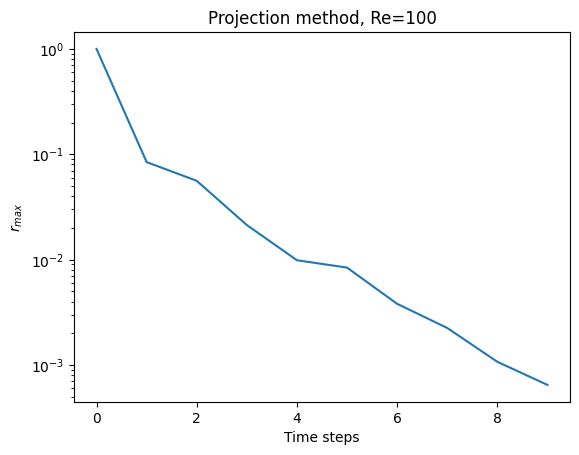

In [146]:
# Final residual        
print(f"Final Iteration = {itr}; Residual = {max_res}")
plt.plot(np.arange(itr), res_hist_classical)
plt.xlabel("Time steps")
plt.ylabel(r"$r_{max}$")
plt.title("Projection method, Re=100")
# plt.grid()
ax = plt.gca()
ax.set_yscale("log")

In [147]:
# Solve x here 
b = R/np.linalg.norm(R)
x = np.linalg.solve(L, b)
x_norm = np.linalg.norm(x)
x_normalized = x/np.linalg.norm(x)

## Construct and visualize VQLS circuit

VQLS works by minizing the following cost function:

$$
C_G =1-|\langle b| \Psi\rangle|^2
= 1 - |\langle 0| U^\dagger A V|0\rangle|^ 2,
$$
where $A$ expressed in linear combination of unitaries (LCU) and  $|b\rangle$ prepared using a unitary $U$
$$
A=\sum_{l=1}^L c_l A_l, |b\rangle = U|0\rangle \Rightarrow 
C_G = 1 - \frac{1}{\mathcal{N}_c}\sum_l c_lc_{l'}^*\langle0| U^{\dagger} A_l V|0\rangle\langle0| V^{\dagger} A_{l^{\prime}}^{\dagger} U|0\rangle 
= 1 - \frac{1}{\mathcal{N}_c} \sum_l c_lc_{l'}^* \gamma_{l l^{\prime}}.
$$

In [148]:
from vqls_prototype import VQLS, VQLSLog
from qiskit.primitives import Estimator, Sampler
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, CG, QNSPSA, POWELL
from qiskit_algorithms import optimizers as opt

N = 4        # number of qubits
dim = 2**N   # dimension of the operator 
ref_solution = x_normalized  # setup reference solution 
ansatz = RealAmplitudes(N, entanglement="linear", reps=5, insert_barriers=False)  # build ansatz

# Initialize Qiskit primitives
estimator = Estimator()
sampler = Sampler()

# Initialize VQLS log
log = VQLSLog([], [])

# Build VQLS solver
vqls = VQLS(
    estimator,
    ansatz,
    opt.COBYLA(maxiter=500, disp=True),
    sampler=sampler,
    options={"use_overlap_test": False, 
             "use_local_cost_function": False,
             "matrix_decomposition": "pauli", 
             # "verbose": True
            },
)

In [149]:
vqls.options

{'use_overlap_test': False,
 'use_local_cost_function': False,
 'matrix_decomposition': 'pauli',
 'shots': None,
 'reuse_matrix': False,
 'verbose': False}

For the $L(L-1) / 2$ terms with $l \neq l^{\prime}$, there are various strategies to estimate $\gamma_{l l^{\prime}}$. For example, one could estimate the $L$ terms of the form $\langle 0| U^{\dagger} A_l V|0\rangle$ with a Hadamard Test, but one would have to control all of the unitaries: $V$, $A_l$, and $U^{\dagger}$. This is how the circuit looks like.

In [150]:
_, qc_test = vqls.construct_circuit(L, b)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 5029.07it/s]


Number of circuits: 22


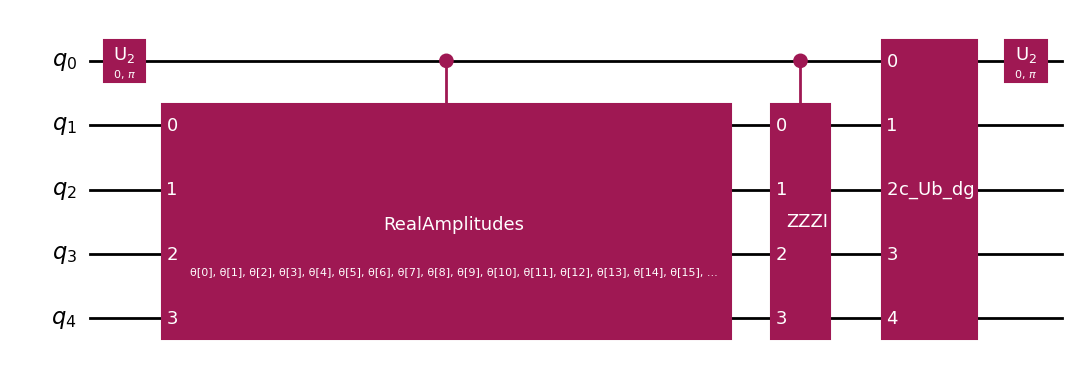

In [151]:
print("Number of circuits:", len(qc_test))
VQLS_cir = qc_test[20].circuits[0]

# Note: if not set "matrix_decomposition": "pauli", circuits[0] computes the real part Re<ψ|U|ψ> in Hadamard test
VQLS_cir.decompose(reps=1).draw("mpl") 

# Note: if not set "matrix_decomposition": "pauli", the following circuits[1] computes the imaginary part Im<ψ|U|ψ> in Hadamard test, which we don't need
# qc_test[0].circuits[1].draw("mpl") 

In [173]:
VQLS_cir.decompose(reps=8).count_ops()

OrderedDict([('u', 528), ('cx', 333)])

### Gate counts for each component

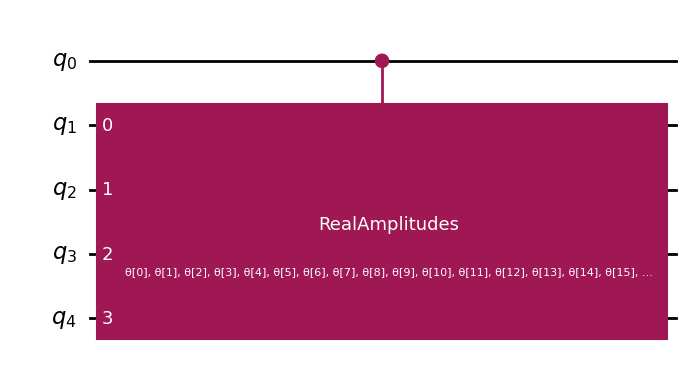

In [153]:
from qiskit import QuantumCircuit

VQLS_cV = QuantumCircuit(5)
VQLS_cV.append(VQLS_cir[1])
VQLS_cV.decompose(reps=1).draw("mpl")

In [154]:
VQLS_cV.decompose(reps=4).count_ops()

OrderedDict([('cx', 138), ('u1', 105), ('u', 96), ('u2', 30)])

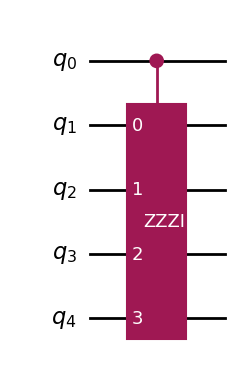

In [155]:
from qiskit import QuantumCircuit

VQLS_cA = QuantumCircuit(5)
VQLS_cA.append(VQLS_cir[2])
VQLS_cA.decompose(reps=1).draw("mpl")

In [156]:
VQLS_cA.decompose(reps=4).count_ops()

OrderedDict([('u3', 6), ('cx', 3)])

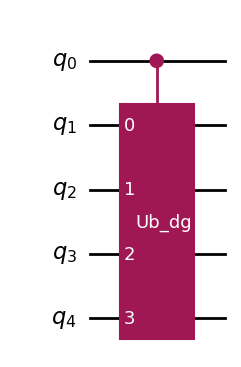

In [157]:
from qiskit import QuantumCircuit

VQLS_cU = QuantumCircuit(5)
VQLS_cU.append(VQLS_cir[3])
VQLS_cU.decompose(reps=2).draw("mpl")

In [158]:
VQLS_cU.decompose(reps=4).count_ops()

OrderedDict([('cx', 192), ('u', 91), ('t', 88), ('tdg', 66), ('h', 44)])

### Matrix decomposition

#### Pauli Decomposition

$$
A=\sum_n c_n P_n
$$

where $P_i$ is the i-th Pauli string, e.g. "XZIY" or "YYZZ". While each Pauli string can be implemented in a very simple quantum circuits, the number of term in the sum above rapidly increases leading to a large number of quantum circuits to evaluate for the calculation of the cost function. 

In [159]:
from qiskit.quantum_info.operators import Operator, SparsePauliOp
PauliString = SparsePauliOp.from_operator(L)
print("Number of Pauli strings:", len(PauliString))
print(PauliString)

Number of Pauli strings: 22
SparsePauliOp(['IIII', 'IIIX', 'IIIZ', 'IIXX', 'IIYY', 'IIZI', 'IIZZ', 'IXII', 'IZII', 'IZIZ', 'IZZI', 'IZZZ', 'XXII', 'YYII', 'ZIII', 'ZIIZ', 'ZIZI', 'ZIZZ', 'ZZII', 'ZZIZ', 'ZZZI', 'ZZZZ'],
              coeffs=[ 46.0625+0.j, -16.    +0.j,  -1.9375+0.j,  -8.    +0.j,  -8.    +0.j,
  -1.9375+0.j,  -9.9375+0.j, -16.    +0.j,  -1.9375+0.j,  -1.9375+0.j,
  -1.9375+0.j,  -1.9375+0.j,  -8.    +0.j,  -8.    +0.j,  -1.9375+0.j,
  -1.9375+0.j,  -1.9375+0.j,  -1.9375+0.j,  -9.9375+0.j,  -1.9375+0.j,
  -1.9375+0.j,  -1.9375+0.j])


In `vqls-prototype`, number of decomposed circuit is equal to number of Pauli strings of matrix $A$ if using Pauli decomposition.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 4613.44it/s]

Number of circuits: 22


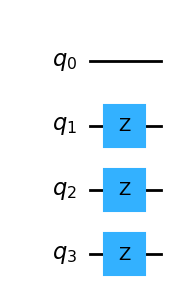

In [160]:
from vqls_prototype.matrix_decomposition import PauliDecomposition

pauli_decomposition = PauliDecomposition(L)
print("Number of circuits:", len(pauli_decomposition.circuits))
pauli_decomposition.circuits[20].draw("mpl")

#### Symmetric Decomposition

Another possible decomposition allows to write a real matrix $A$ as a weighted sum of two unitary matrices

$$
A=\frac{1}{2}\left(A_{+}+A_{-}\right)
$$

with

$$
A_{ \pm}=A \pm i \sqrt{I-A^2}
$$

and with $A_{ \pm}$both unitary matrices. The same analysis can be done for complex matrices by consdireding their real and imaginary parts separately. Since the matrices $A_{ \pm}$are unitary they can be implemented in a quantum circuit.

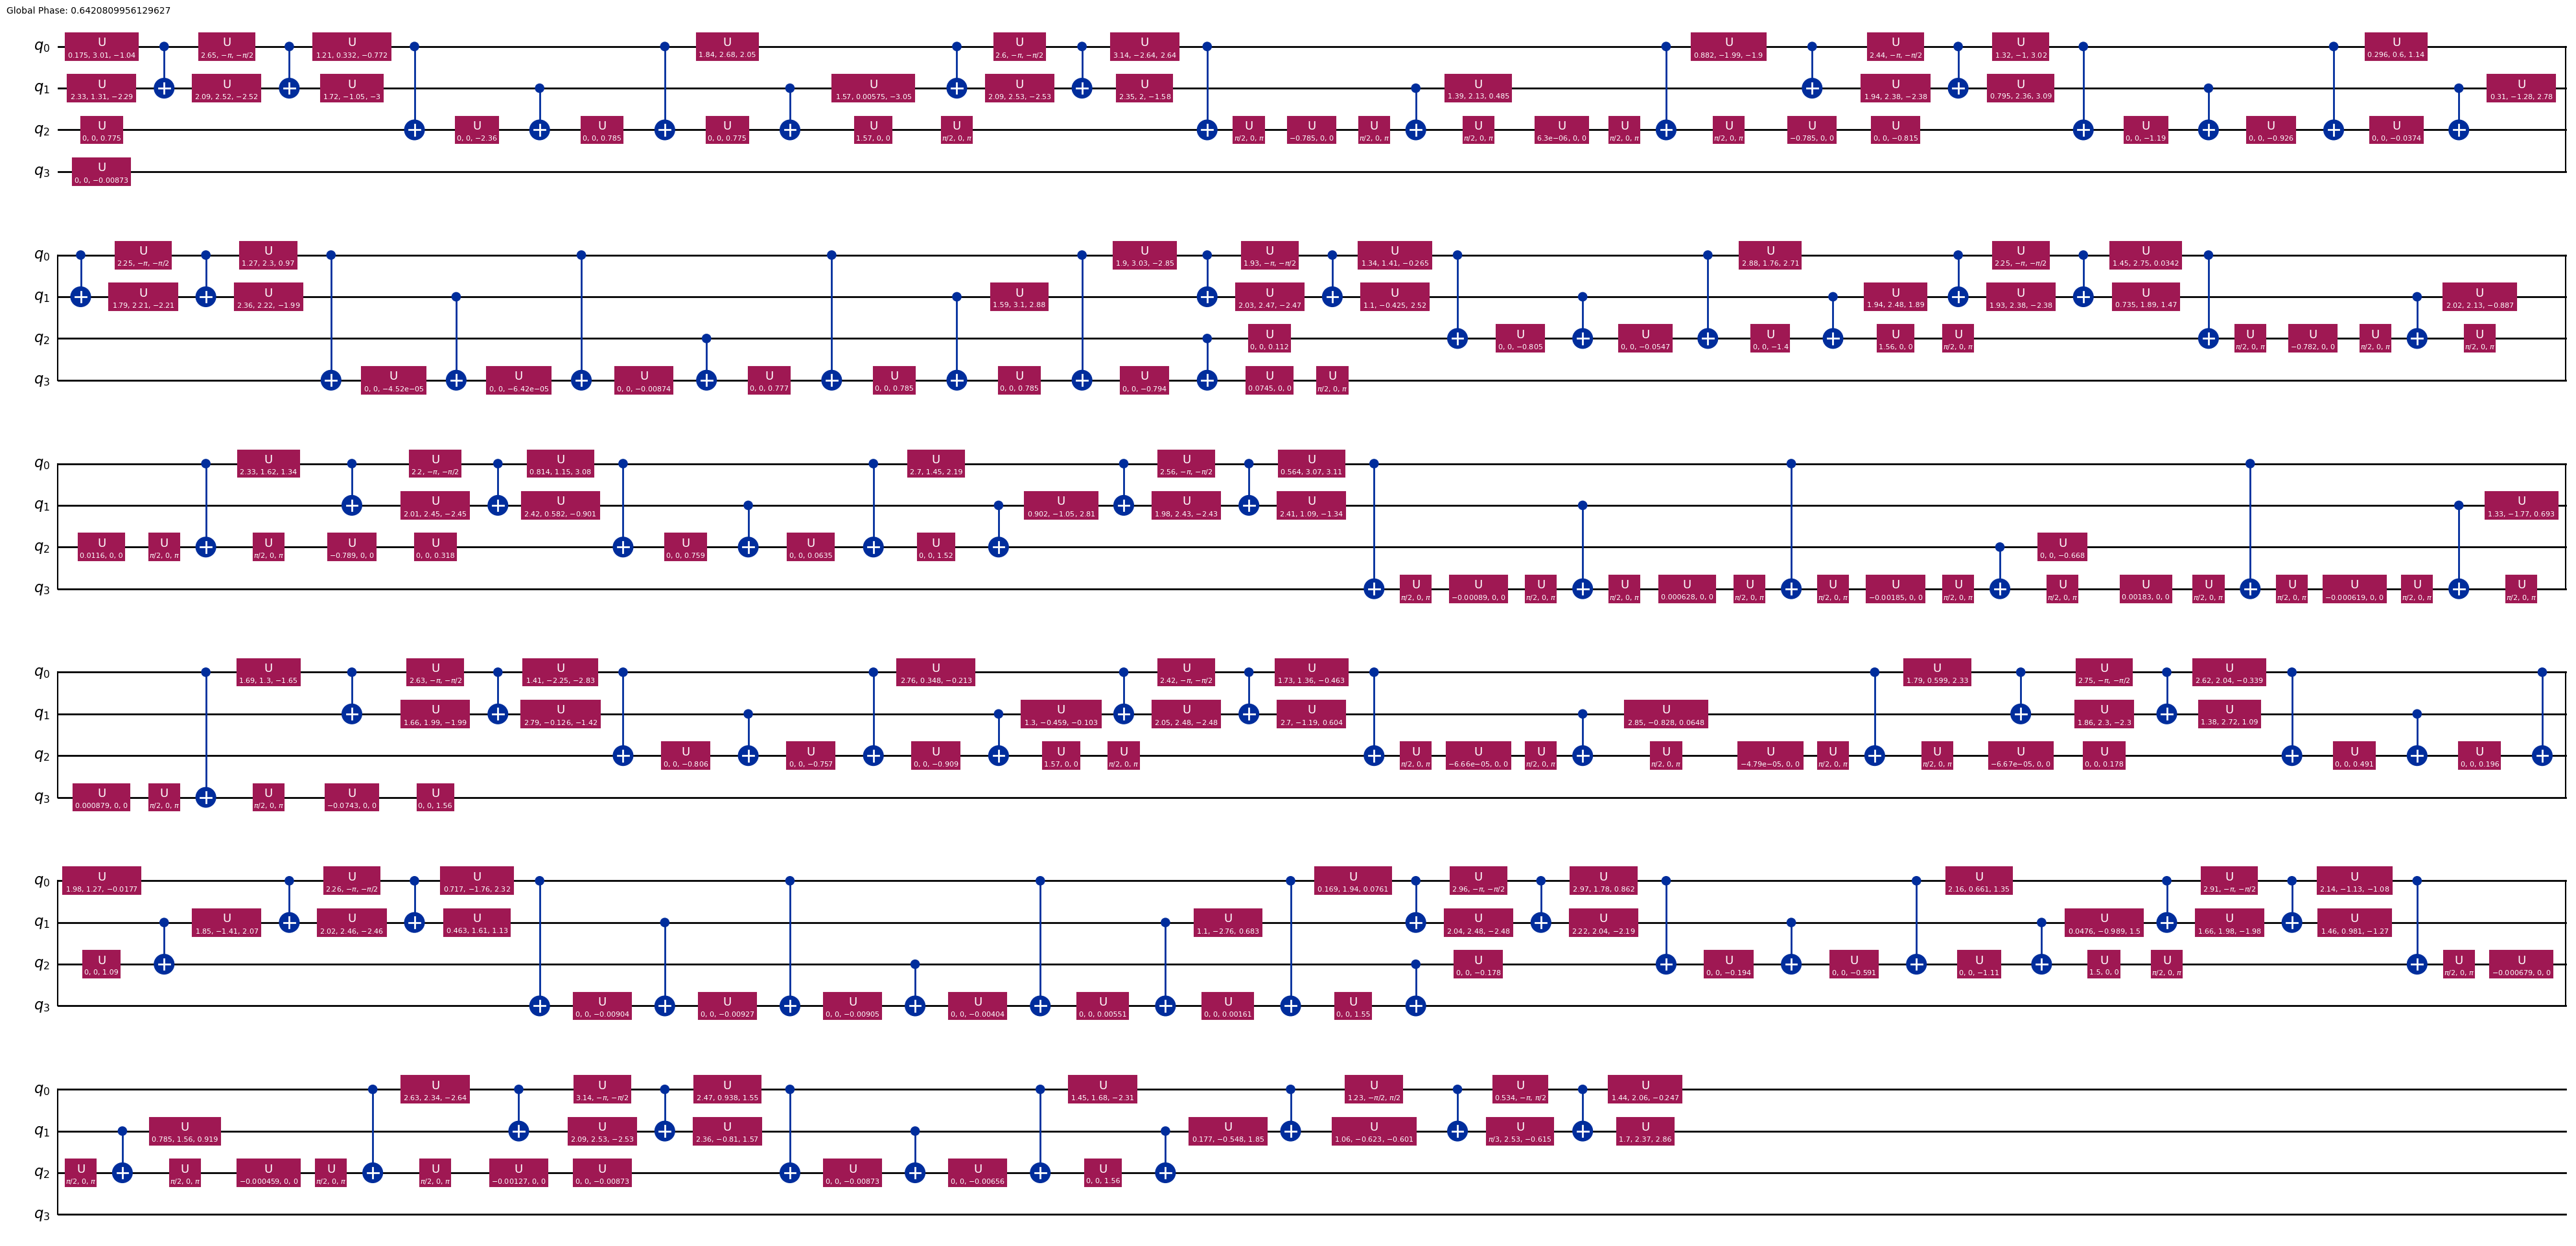

In [163]:
from vqls_prototype.matrix_decomposition import SymmetricDecomposition

symmetric_decomposition = SymmetricDecomposition(L)
symmetric_decomposition.circuits[0].decompose(reps=2).draw("mpl", fold=60)

In [164]:
symmetric_decomposition.circuits[0].decompose(reps=4).count_ops()

OrderedDict([('u', 208), ('cx', 100)])

The `SymmetricDecomposition` leads to only **two circuits** for a real matrix $A$ but the resulting circuits are much more complicated than the ones obtained via `the PauliDecomposition`.

#### Hadammard test (default) and Overlap test (Hadammard + SWAP test)

Hadamard-Overlap Test that directly computes $\gamma_{l l^{\prime}}$ without having to control $V$ or $U$ at the expense of doubling the number of qubits. This circuit looks like

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 2634.43it/s]


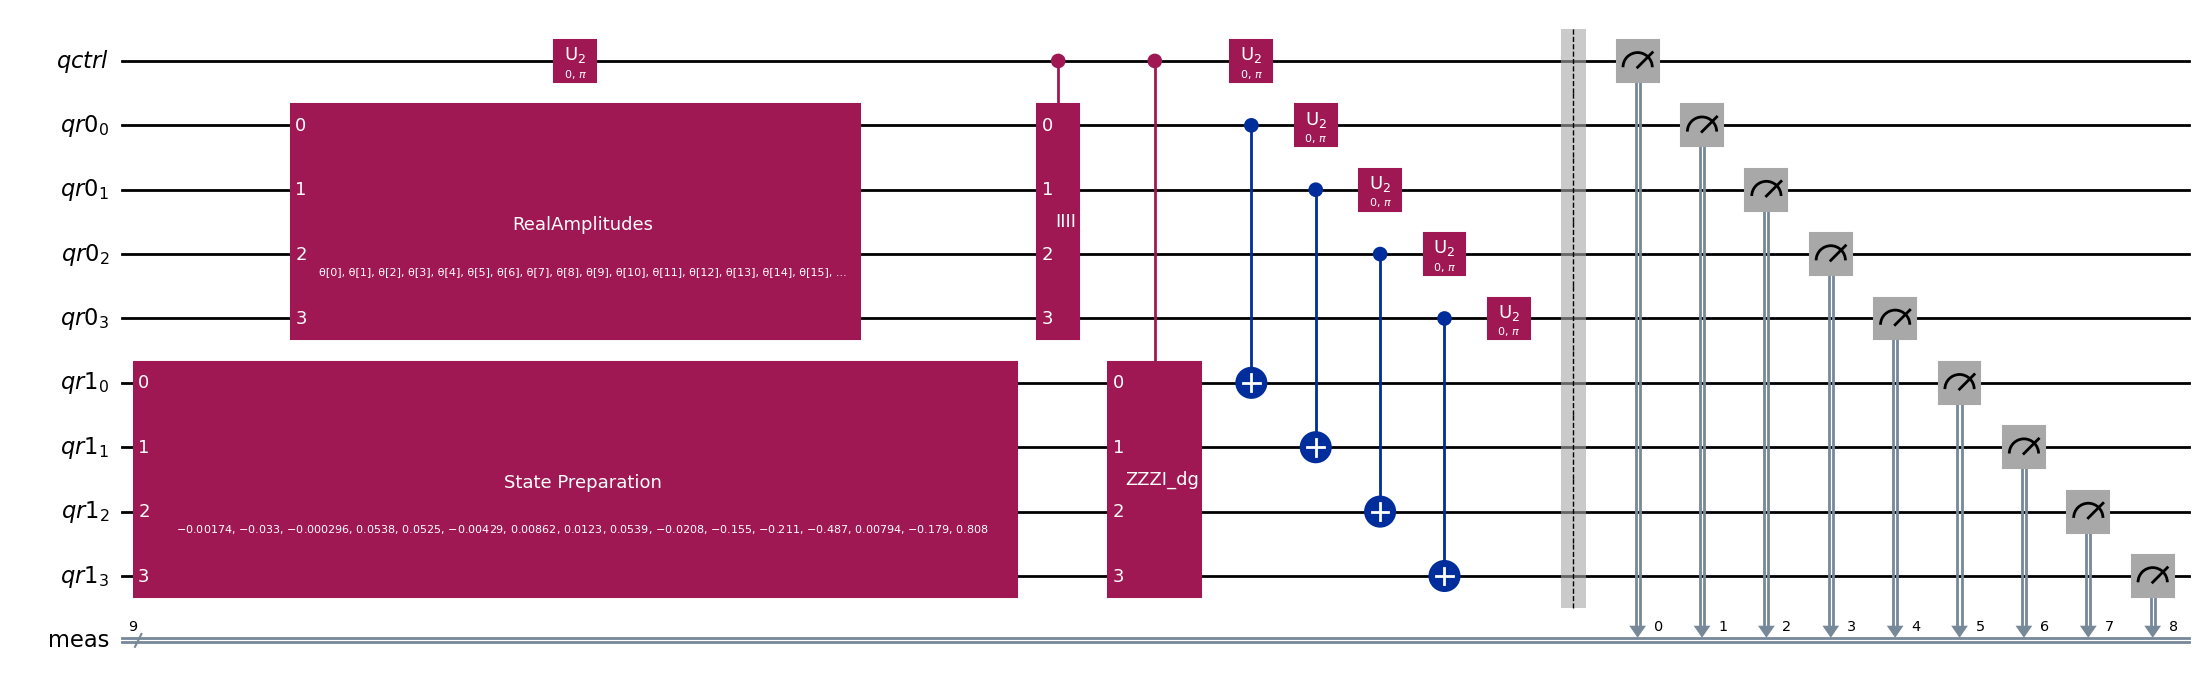

In [177]:
vqls.options = vqls._validate_solve_options({"use_overlap_test": True, "matrix_decomposition": "pauli"})
_, qc_test = vqls.construct_circuit(L, b)
qc_test[20].circuits[0].decompose().draw("mpl", fold=-1)

In [179]:
qc_test[20].circuits[0].decompose(reps=8).count_ops()

OrderedDict([('cx', 44),
             ('u', 42),
             ('measure', 9),
             ('r', 8),
             ('u3', 8),
             ('u1', 8),
             ('barrier', 1)])

This is actually using more gates than the original Hadamard test!

### Global (default) and local cost function

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 4038.69it/s]


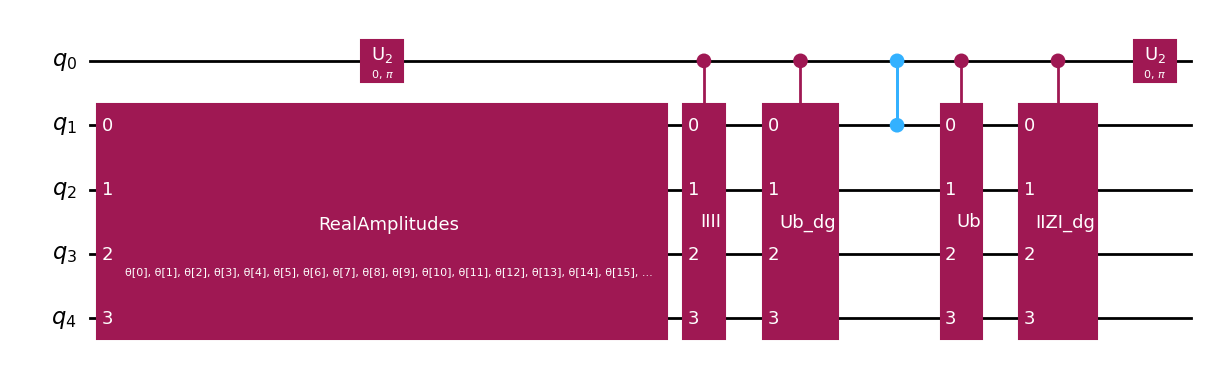

In [181]:
vqls.options = vqls._validate_solve_options({"use_local_cost_function": True, "matrix_decomposition": "pauli"})
_, qc_test = vqls.construct_circuit(L, b)
qc_test[20].circuits[0].decompose(reps=1).draw("mpl", fold=-1)

In [182]:
qc_test[20].circuits[0].decompose(reps=8).count_ops()

OrderedDict([('u', 608), ('cx', 401)])

## Solve the linear system using VQLS

In [89]:
# Build VQLS solver
vqls = VQLS(
    estimator,
    ansatz,
    opt.L_BFGS_B(maxiter=500, tol=1e-4),
    sampler=sampler,
    options={"use_overlap_test": False, 
             "use_local_cost_function": False,
             "matrix_decomposition": "pauli", 
             "verbose": True
            },
)

# Run VQLS solver
res = vqls.solve(L, b)

In [90]:
vqls.options

{'use_overlap_test': False,
 'use_local_cost_function': False,
 'verbose': True,
 'matrix_decomposition': 'symmetric',
 'shots': None,
 'reuse_matrix': False}

Text(0.5, 0, 'Iterations')

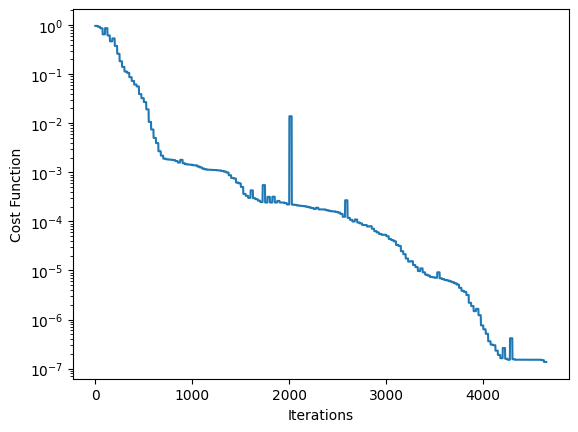

In [91]:
import matplotlib.pyplot as plt

plt.semilogy(vqls.logger.values)
plt.ylabel("Cost Function")
plt.xlabel("Iterations")

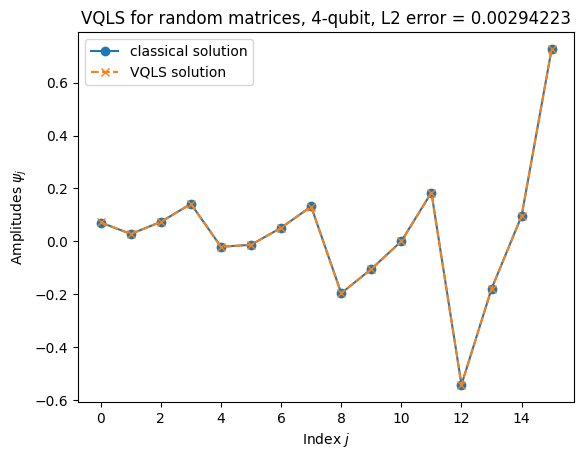

In [94]:
from qiskit.quantum_info import Statevector

vqls_solution = np.real(Statevector(res.state).data)
err = np.linalg.norm(ref_solution - vqls_solution)

plt.plot(ref_solution, "o-", label="classical solution")
plt.plot(vqls_solution, "x--", label="VQLS solution")
plt.xlabel(r"Index $j$")
plt.ylabel(r"Amplitudes $\psi_j$")
plt.title("VQLS for random matrices, {0}-qubit, L2 error = {1:.8f}".format(N, err))
plt.legend()